<a href="https://colab.research.google.com/github/yihan-hu-ai/nuplan-devkit/blob/master/%5BML%5D_transformers_debug_kv_cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

# **Task Overview: Image Generation with Autoregessive Transformers**

## Primary Task

	1.	Fix Bugs in Transformers
	  •	Identify and resolve approximately 5 bugs.
	2.	Optimize Training Loss and Quality
    •	Ensure the training loss is below 2.8.
    •	Achieve reasonable image generation quality.

## Several follow-up afterwards

In [ ]:
!pip install torch torchvision

In [ ]:
from __future__ import print_function
import argparse
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

Let's load the MNIST Dataset!

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch

class CustomMNIST(MNIST):
    """
    MNIST dataset that downloads from a custom GitHub mirror.
    """

    # Override the mirrors with the raw GitHub URLs
    mirrors = [
        "https://raw.githubusercontent.com/mkolod/MNIST/master/"  # Custom mirror URL
    ]

    # Keep the same resource filenames and MD5 checksums
    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c"),
    ]

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform=None,
        target_transform=None,
        download: bool = False,
    ):
        super().__init__(
            root=root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download,
        )

In [ ]:
class MNISTSequenceDataset(Dataset):
    def __init__(self, train=True, data_dir='../data', samples_per_class=100):
        """
        Args:
            train (bool): Whether to load the training set.
            data_dir (str): Directory where MNIST data is stored/downloaded.
            samples_per_class (int): Number of samples per class in training mode.
        """
        self.dataset = CustomMNIST(
            root=data_dir,
            train=train,
            download=True,  # Downloads from the custom mirror
            transform=transforms.Compose([
                transforms.Resize((7, 7)),  # Resize images to 7x7
                transforms.ToTensor()
            ])
        )

        if train:
            # Subsample the dataset to `samples_per_class` samples per class
            targets = self.dataset.targets
            num_classes = 10
            samples_per_class = samples_per_class  # Number of samples per class
            indices = []
            for c in range(num_classes):
                # Get indices of all samples belonging to class c
                class_indices = (targets == c).nonzero(as_tuple=False).view(-1)
                # Select the first 'samples_per_class' indices
                class_indices = class_indices[:samples_per_class]
                indices.extend(class_indices.tolist())
            self.indices = indices
        else:
            # For the test set, use the full set
            self.indices = list(range(len(self.dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.dataset[real_idx]
        img = img.view(-1)            # Flatten image to (7*7,)
        img = (img * 255).long()      # Scale pixel values to 0-255 and convert to long
        return img

Let's Build the model! There will be total 5 bugs after the block.

In [ ]:
class SimpleGPT(nn.Module):
    def __init__(self, vocab_size=256, max_seq_len=49, embedding_dim=128, num_heads=4, num_layers=4, dropout=0.1):
        super(SimpleGPT, self).__init__()
        self.token_embedding = nn.Parameter(torch.zeros(vocab_size, embedding_dim))
        self.layers = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        batch_size, seq_len = x.size()
        x = self.token_embedding[x]
        for layer in self.layers:
            x = layer(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super(TransformerBlock, self).__init__()
        self.attn = MaskedMultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.GELU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class MaskedMultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super(MaskedMultiHeadSelfAttention, self).__init__()
        assert embedding_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Separate projections for Q, K, V
        self.q_proj = nn.Linear(embedding_dim, embedding_dim)
        self.k_proj = nn.Linear(embedding_dim, embedding_dim)
        self.v_proj = nn.Linear(embedding_dim, embedding_dim)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, embedding_dim = x.size()

        # Project inputs to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply attention mask
        attn_weights = self.apply_mask(attn_weights)

        # Softmax and dropout
        attn_probs = torch.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Compute attention output
        attn_output = torch.matmul(attn_probs, q)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, embedding_dim)
        output = self.out_proj(attn_output)
        return output

    def apply_mask(self, attn_weights):
        batch_size, num_heads, seq_len_q, seq_len_k = attn_weights.size()
        device = attn_weights.device
        mask = torch.triu(torch.ones(seq_len_q, seq_len_k, device=device), diagonal=1).bool()
        attn_weights = attn_weights.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('inf'))
        return attn_weights

# Training Code
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch[:, 1:])
        loss = criterion(logits.reshape(-1, logits.size(-1)), batch[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

All the bugs exist in the block above!

Let's Train the model! The correct code should get the loss below 2.8.

In [ ]:
    # Hyperparameters
    embedding_dim = 32
    num_heads = 4
    num_layers = 4
    dropout = 0.1
    batch_size = 256
    epochs = 30
    lr = 1e-2
    seq_len = 49
    vocab_size = 256

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare data
    train_dataset = MNISTSequenceDataset(train=True)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and loss function
    model = SimpleGPT(vocab_size, seq_len, embedding_dim, num_heads, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in tqdm.tqdm(range(1, epochs + 1)):
        loss = train(model, train_dataloader, optimizer, criterion, device)
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 110MB/s]

Extracting ../data/CustomMNIST/raw/train-images-idx3-ubyte.gz to ../data/CustomMNIST/raw


100%|██████████| 28.9k/28.9k [00:00<00:00, 3.83MB/s]


Extracting ../data/CustomMNIST/raw/train-labels-idx1-ubyte.gz to ../data/CustomMNIST/raw



100%|██████████| 1.65M/1.65M [00:00<00:00, 32.7MB/s]


Extracting ../data/CustomMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/CustomMNIST/raw



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.21MB/s]


Extracting ../data/CustomMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/CustomMNIST/raw



  3%|▎         | 1/30 [00:03<01:55,  3.97s/it]

Epoch 1, Loss: nan


  7%|▋         | 2/30 [00:07<01:48,  3.89s/it]

Epoch 2, Loss: nan


 10%|█         | 3/30 [00:13<02:09,  4.79s/it]

Epoch 3, Loss: nan


 13%|█▎        | 4/30 [00:16<01:47,  4.13s/it]

Epoch 4, Loss: nan


 17%|█▋        | 5/30 [00:18<01:24,  3.37s/it]

Epoch 5, Loss: nan


 20%|██        | 6/30 [00:20<01:08,  2.84s/it]

Epoch 6, Loss: nan


 23%|██▎       | 7/30 [00:22<01:01,  2.68s/it]

Epoch 7, Loss: nan


 27%|██▋       | 8/30 [00:25<01:00,  2.75s/it]

Epoch 8, Loss: nan


 30%|███       | 9/30 [00:27<00:53,  2.54s/it]

Epoch 9, Loss: nan


 33%|███▎      | 10/30 [00:30<00:47,  2.40s/it]

Epoch 10, Loss: nan


 37%|███▋      | 11/30 [00:31<00:42,  2.22s/it]

Epoch 11, Loss: nan


 40%|████      | 12/30 [00:33<00:38,  2.15s/it]

Epoch 12, Loss: nan


 43%|████▎     | 13/30 [00:35<00:35,  2.11s/it]

Epoch 13, Loss: nan


 47%|████▋     | 14/30 [00:38<00:35,  2.23s/it]

Epoch 14, Loss: nan


 50%|█████     | 15/30 [00:40<00:32,  2.17s/it]

Epoch 15, Loss: nan


 53%|█████▎    | 16/30 [00:42<00:30,  2.16s/it]

Epoch 16, Loss: nan


 57%|█████▋    | 17/30 [00:44<00:28,  2.18s/it]

Epoch 17, Loss: nan


 60%|██████    | 18/30 [00:46<00:26,  2.19s/it]

Epoch 18, Loss: nan


 63%|██████▎   | 19/30 [00:49<00:24,  2.20s/it]

Epoch 19, Loss: nan


 67%|██████▋   | 20/30 [00:51<00:23,  2.32s/it]

Epoch 20, Loss: nan


 70%|███████   | 21/30 [00:53<00:19,  2.19s/it]

Epoch 21, Loss: nan


 73%|███████▎  | 22/30 [00:55<00:16,  2.10s/it]

Epoch 22, Loss: nan


 77%|███████▋  | 23/30 [00:57<00:14,  2.07s/it]

Epoch 23, Loss: nan


 80%|████████  | 24/30 [01:00<00:13,  2.29s/it]

Epoch 24, Loss: nan


 83%|████████▎ | 25/30 [01:03<00:12,  2.41s/it]

Epoch 25, Loss: nan


 87%|████████▋ | 26/30 [01:05<00:09,  2.36s/it]

Epoch 26, Loss: nan


 90%|█████████ | 27/30 [01:07<00:06,  2.31s/it]

Epoch 27, Loss: nan


 93%|█████████▎| 28/30 [01:09<00:04,  2.20s/it]

Epoch 28, Loss: nan


 97%|█████████▋| 29/30 [01:11<00:02,  2.13s/it]

Epoch 29, Loss: nan


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]

Epoch 30, Loss: nan


Generation Code

In [ ]:
def generate_batch_no_cache(model, start_tokens, seq_len, device):
    model.eval()
    batch_size = start_tokens.size(0)

    # Initialize input_ids with start tokens
    input_ids = start_tokens.unsqueeze(1).to(device)
    generated_tokens = input_ids

    with torch.no_grad():
        for _ in range(seq_len - 1):
            # Pass the entire sequence each time
            logits = model(generated_tokens)
            next_token_logits = logits[:, -1, :]
            probs = torch.softmax(next_token_logits, dim=-1)
            next_tokens = torch.multinomial(probs, num_samples=1)

            # Append the generated token
            generated_tokens = torch.cat([generated_tokens, next_tokens], dim=1)

    return generated_tokens

In [ ]:

import time

num_samples = 20
batch_size = num_samples
start_tokens = torch.zeros(batch_size, dtype=torch.long)  # Start tokens for all sequences

# Time without kv cache
start_time = time.time()
generated_sequences_no_cache = generate_batch_no_cache(model, start_tokens, seq_len, device).cpu().numpy()
time_no_cache = time.time() - start_time

dataset_images = []
sampled_indices = np.random.randint(0, len(train_dataset), num_samples)
for idx in sampled_indices:
    img_seq = train_dataset[idx].numpy()
    img = img_seq.reshape(7, 7)
    dataset_images.append(img)

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

Let's check the generation quality, we should be able to get some how reasonable digit looks like this:

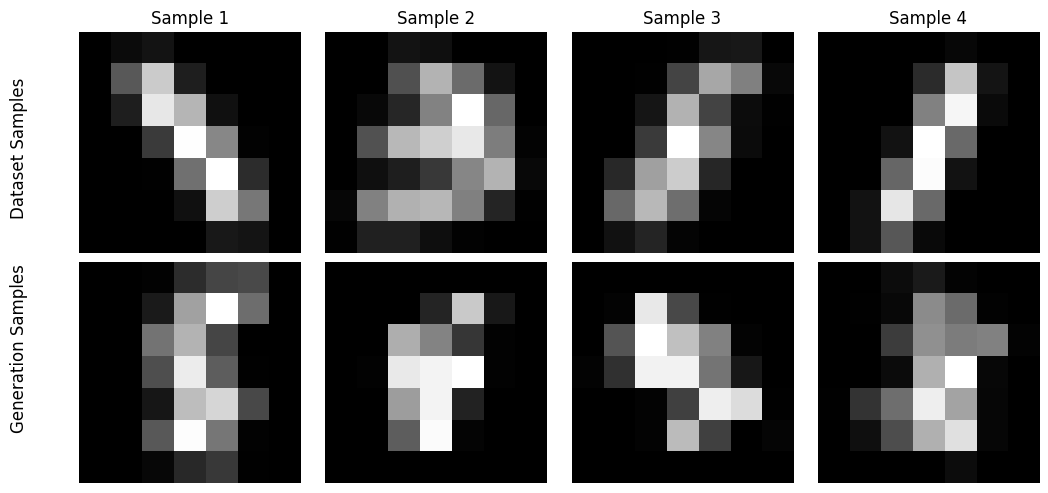

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Add row labels
fig.text(-0.04, 0.7, 'Dataset Samples', va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(-0.04, 0.3, 'Generation Samples', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(4):
    # Display dataset image in the first row
    axes[0, i].imshow(dataset_images[i], cmap='gray', interpolation='nearest')
    axes[0, i].set_title(f'Sample {i+1}')
    axes[0, i].axis('off')

    # Display generated image in the second row
    axes[1, i].imshow(generated_sequences_no_cache[i].reshape(7, 7), cmap='gray', interpolation='nearest')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Follow-Up: Key-Value Caching Implementation

	•	Implement a key-value caching mechanism to achieve at least a 2x speedup.
	•	Maintain identical performance with the optimized mechanism.

In [ ]:
def generate_batch(model, start_tokens, seq_len, device):
    model.eval()
    batch_size = start_tokens.size(0)

    # Initialize input_ids with start tokens
    input_ids = start_tokens.unsqueeze(1).to(device)  # Shape: (batch_size, 1)
    generated_tokens = input_ids
    #### code start here ###


    ########################

    return generated_tokens

Let's test the runtime! You will measure how many time speed up by using kv cahe!

In [ ]:
import time

num_samples = 20
batch_size = num_samples
start_tokens = torch.zeros(batch_size, dtype=torch.long)  # Start tokens for all sequences

# Time without kv cache
start_time = time.time()
generated_sequences_no_cache = generate_batch_no_cache(model, start_tokens, seq_len, device).cpu().numpy()
time_no_cache = time.time() - start_time

# Time with kv cache
start_time = time.time()
generated_sequences_with_cache = generate_batch(model, start_tokens, seq_len, device).cpu().numpy()
time_with_cache = time.time() - start_time

print(f"Time without kv cache: {time_no_cache:.4f} seconds")
print(f"Time with kv cache: {time_with_cache:.4f} seconds")

Let's check the generation quality!

In [ ]:
dataset_images = []
for idx in sampled_indices:
    img_seq = train_dataset[idx].numpy()
    img = img_seq.reshape(7, 7)
    dataset_images.append(img)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(10, 5))

for i in range(5):
    # Display dataset image in the first row
    axes[0, i].imshow(dataset_images[i], cmap='gray', interpolation='nearest')
    axes[0, i].set_title(f'Sample {i+1}')
    axes[0, i].axis('off')

    # Display generated image in the second row
    axes[1, i].imshow(generated_sequences_with_cache[i].reshape(7, 7), cmap='gray', interpolation='nearest')
    axes[1, i].axis('off')

    # Display generated image in the second row
    axes[2, i].imshow(generated_sequences_no_cache[i].reshape(7, 7), cmap='gray', interpolation='nearest')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Follow-up questions